In [1]:
import copy
import os
#from nflows import transforms, distributions, flows
import torch
from scipy.special import logsumexp
from scipy.optimize import curve_fit
from scipy import integrate

from torch import nn
from torch import optim
import torch.distributions as D
import emcee
import corner
import time
from multiprocessing import cpu_count, Pool

import os
import h5py 
import numpy as np
# import fitsio
# from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM

# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## FileEmcee class

In [2]:
class FileEmcee:
    def __init__(self, z_dependence, bin_test, info_file):
        self.emcee_runs_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/emcee_runs'
        self.bin_tests_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/emcee_runs/bin_tests_runs'
        self.gmm_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/gmm'
        
        self.z_dep = z_dependence
        self.bin_test = bin_test
        self.info_file = info_file

    
    def get_list_file(self):
        if self.bin_test:
            if self.z_dep:
                return [os.path.join(self.bin_tests_dir,file) for file in os.listdir(self.bin_tests_dir) if file.startswith('Z')]
            else:
                return [os.path.join(self.bin_tests_dir,file) for file in os.listdir(self.bin_tests_dir) if file.startswith('Noz')]


    def get_file(self):
        list_file = self.get_list_file()
        
        found_file = [file for file in list_file if self.info_file in file]
        
        if len(found_file) > 1:
            return found_file
        else:
            return found_file[0]   

## EmceeRun class

In [3]:
class EmceeRun(FileEmcee):
    def __init__(self, file_emcee_obj):
        super().__init__(file_emcee_obj.z_dep, file_emcee_obj.bin_test, file_emcee_obj.info_file)
        self.file_emcee_obj = file_emcee_obj
        
        self.emcee_file = self.get_file()

    
        self.reader = emcee.backends.HDFBackend(self.emcee_file)
        self.samples = self.reader.get_chain()  

        self.labels4 = [r'$a_{0}$', r'$a_{1}$', r'$a_{3}$', r'$a_{3}$']
        self.labels2 = [r'$\log(M_{*})$', r'$\alpha_{1}$']

    def set_best_params(self, discard):
         self.flat_samples = self.reader.get_chain(discard=discard, thin=15, flat=True)
         mcmc = np.array([np.percentile(self.flat_samples[:, i], [16, 50, 84]) for i in range(self.flat_samples.shape[1])])
         self.best_params = mcmc[:,1]

    
    def get_best_params(self):
        return self.best_params

## Data - BGS class

In [4]:
class Data:
    def __init__(self, file):
        self.data_dir = '/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/data'
        self.file = file
        self.data_file = os.path.join(self.data_dir, self.file)

    
    def get_data(self):
        if self.file.endswith('.hdf5'):
            return aTable.Table.read(self.data_file)
        elif self.file.endswith('.dat'):
            return np.loadtxt(self.data_file, unpack=True, usecols=[0, 1, 2])



class BGS(Data):
    def __init__(self, file, is_bgs_bright=True):
        super().__init__(file)

        self.f_area = (173.641/(4.*np.pi*(180/np.pi)**2))

        if is_bgs_bright:
            self.is_bgs = 'is_bgs_bright'
        else:
            self.is_bgs = 'is_bgs_faint'


        bgs_all = self.get_data()
        bgs = bgs_all[bgs_all[self.is_bgs]]
        self.z = bgs['Z_HP'].data
        self.x = bgs['provabgs_logMstar'].data
        self.x_median = np.median(self.x, axis=1)
        self.w_zfail = bgs['provabgs_w_zfail'].data
        self.w_fib = bgs['provabgs_w_fibassign'].data
        self.w_spec = self.w_zfail * self.w_fib
        self.vmax = bgs['Vmax'].data
        

        # Setting attributes for the mass completeness limit parameters
        self.f = -1.34199453
        self.b = 13.90578909
        self.c = 8.53522654
        

    
    def select_galaxies(self, zmin, zmax):
        mask_zlim = (self.z > zmin) & (self.z < zmax) & (self.x_median > self.mass_completeness_limit(self.z))
        
        v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * self.f_area # (Mpc/h)^3
        v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * self.f_area# (Mpc/h)^3
    
        z = self.z[mask_zlim]
        x = self.x[mask_zlim]
        x_median = self.x_median[mask_zlim]
        w_zfail = self.w_zfail[mask_zlim]
        w_fib = self.w_fib[mask_zlim]
        w_spec = self.w_spec[mask_zlim]
        vmax = (self.vmax.clip(v_zmin, v_zmax) - v_zmin)[mask_zlim]
        
        return z, x, x_median, w_spec, vmax
        

    
    
    def mass_completeness_limit(self, z):
        return 4 * np.pi * self.f * z**2 + self.b * z + self.c


    
    def get_number_galaxies(self):
        if self.z.shape[0] == self.x.shape[0]:
            return self.z.shape[0]


## Plotter class

In [5]:
class Plotter(BGS, EmceeRun):
    def __init__(self, bgs, emcee_run):
        BGS.__init__(self, bgs.file, bgs.is_bgs)
        EmceeRun.__init__(self, emcee_run.file_emcee_obj)
        
        self.z_lin = np.linspace(0, 0.65, 100)
        # self.x_lin = np.linspace()

    
    def plot_selected_data(self, zmin, zmax):
        z, x, x_median, w_spec, vmax = self.select_galaxies(zmin, zmax)
        
        fig, ax = plt.subplots(figsize=(8,6))
        ax.scatter(self.z, self.x_median, s=1, c='lightgrey', label='BGS Bright')
        ax.scatter(z, x_median, s=1, c='C0', label='BGS Bright Mlim')
        ax.plot(self.z_lin, self.mass_completeness_limit(self.z_lin), color = 'orange', linewidth=0.9)
       
        ax.legend(loc='lower right', fontsize=15, markerscale=10, handletextpad=0.1)
        ax.set_xlabel(r"redshift ($z$)", fontsize=15)
        ax.set_xlim(0., 0.65)
        ax.set_ylabel(r"best-fit $\log M_*$", fontsize=15)
        ax.set_ylim(6., 13.2)

        return fig, ax


    def plot_emcee_samples(self):
        
        if self.z_dep:
            ndim = 4
            # labels = [r'$a_{0}$', r'$a_{1}$', r'$a_{3}$', r'$a_{3}$']
        
        
            fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
            
            for i in range(ndim):
                ax = axes[i]
                ax.plot(self.samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(self.samples))
                ax.set_ylabel(self.labels4[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)
                axes[-1].set_xlabel("step number")
        else:
            ndim = 2
            # labels = [r'$\log(M_{*})$', r'$\alpha_{1}$']
        
        
            fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
            
            for i in range(ndim):
                ax = axes[i]
                ax.plot(self.samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(self.samples))
                ax.set_ylabel(self.labels2[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)
                axes[-1].set_xlabel("step number")


    def plot_emcee_corner(self, flat_samples, labels):
        fig = corner.corner(flat_samples, labels=labels, quantiles=(0.16, 0.50, 0.84), show_titles=True);
        plt.show()

## NoZSchechter Model class

In [6]:
class NoZSchechterModel(BGS):
    def __init__(self, bgs, zmin, zmax):
        super().__init__(bgs.file, bgs.is_bgs)
        self.zmin = zmin
        self.zmax = zmax

        self.z, self.x, self.x_median, self.w_spec, self.vmax = self.select_galaxies(zmin, zmax)
        self.mlim = self.mass_completeness_limit(self.z)
        

    @staticmethod
    def phi(x, logM, alpha1):
        term0 = np.log(10) * np.exp(-10 ** (x-logM))
        term1 = 10 ** ((alpha1+1)*(x - logM))
        return term0 * term1


    def integral_phi(self, logM, alpha1):
        return np.array([integrate.quad(NoZSchechterModel.phi, self.mlim[i], 13., args=(logM, alpha1))[0] for i in range(len(self.mlim))])

    
    def log_likelihood(self, logM, alpha1):
        I = self.integral_phi(logM, alpha1)
        q = NoZSchechterModel.phi(self.x, logM, alpha1)
        a = np.log(np.sum(q, axis=1)) - np.log(I)
        return a * self.w_spec


    def log_prior(self, theta):
        logM, alpha1 = theta
        if 9.5 < logM < 13.5 and \
            -5. < alpha1 < 0. :
            return 0
        return -np.inf


    def posterior(self, theta):
        logM, alpha1 = theta
        l = self.log_likelihood(logM, alpha1)
        return self.log_prior(theta) + np.sum(l)

# Main

In [7]:
bgs_bright = BGS('BGS_ANY_full.provabgs.lite.hdf5', is_bgs_bright=True)
bgs_faint = BGS('BGS_ANY_full.provabgs.lite.hdf5', is_bgs_bright=False)
emcee_file = FileEmcee(z_dependence=False, bin_test=True, info_file='0.13_0.17')

In [8]:
emcee_run = EmceeRun(emcee_file)

In [9]:
emcee_run.emcee_file

'/Users/federico/OneDrive - University College London/PhD/PhD_project/bgs_psmf/emcee_runs/bin_tests_runs/NozSchechter_20w_300step_0.13_0.17.h5'

In [10]:
plotter_bright = Plotter(bgs_bright, emcee_run)
plotter_faint = Plotter(bgs_faint, emcee_run)

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='redshift ($z$)', ylabel='best-fit $\\log M_*$'>)

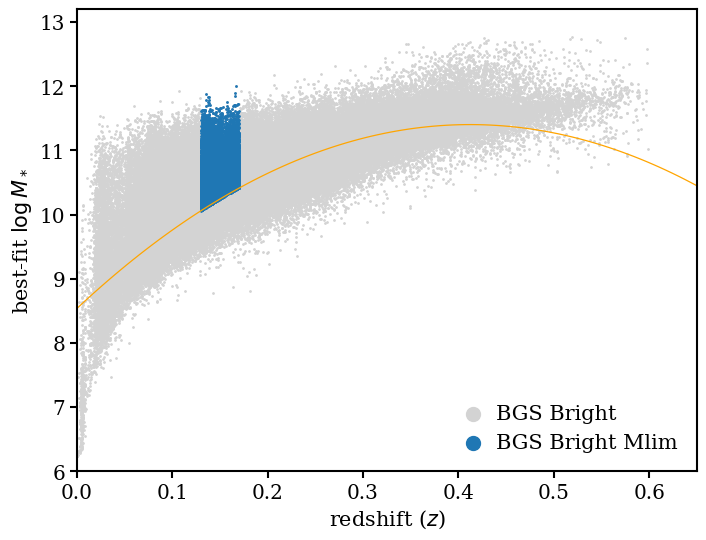

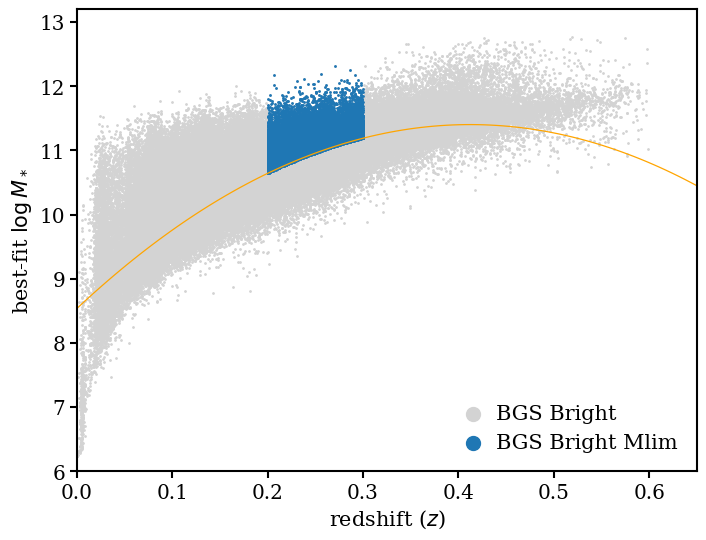

In [11]:
fig, ax = plotter_bright.plot_selected_data(0.13, 0.17)
plotter_faint.plot_selected_data(0.2, 0.3)

In [12]:
bgs_bright.is_bgs, bgs_faint.is_bgs, bgs_bright.x.shape, bgs_faint.x.shape

('is_bgs_bright', 'is_bgs_faint', (143017, 100), (95499, 100))

In [13]:
smf = NoZSchechterModel(bgs_bright, 0.01, 0.05)

In [14]:
smf.mass_completeness_limit(smf.z)

array([8.95509433, 9.13264614, 9.13337446, ..., 8.90665784, 9.12633211,
       9.03364454])

In [15]:
NoZSchechterModel.phi(smf.x_median, 10.5, -1)

array([2.10150603, 1.76551371, 0.59832267, ..., 2.17873646, 2.19832152,
       2.07764204])

In [16]:
smf.log_likelihood(10.5, -1)

array([4.2504337 , 4.22131747, 3.20745088, ..., 4.24932532, 8.40072015,
       4.3203026 ])

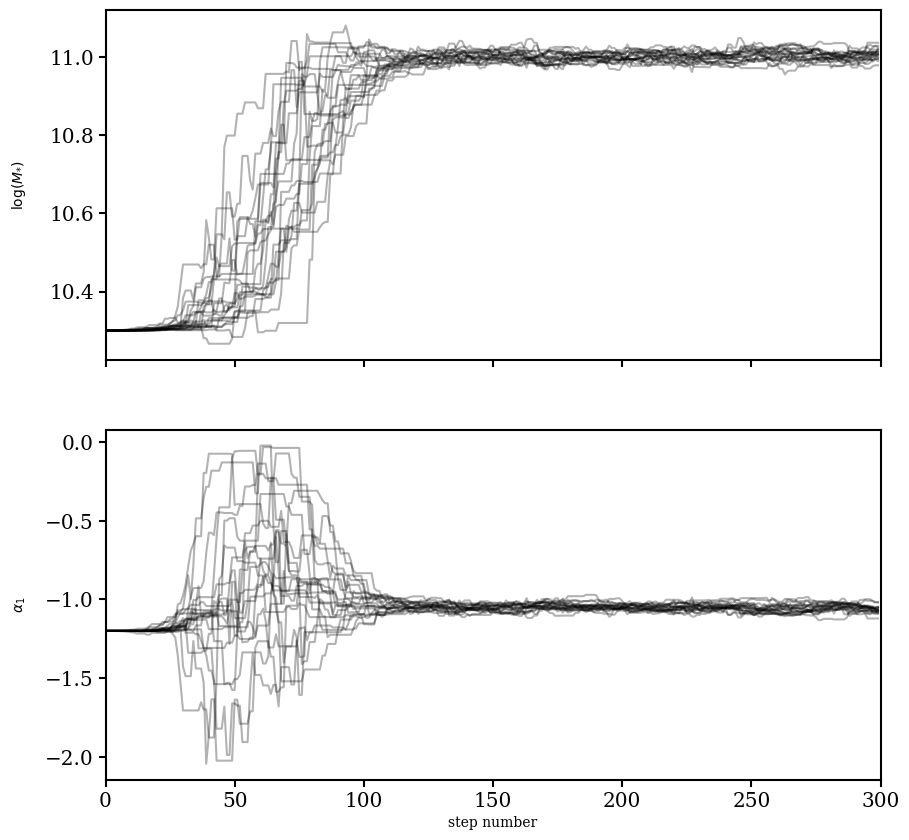

In [16]:
plotter.plot_emcee_samples()

In [17]:
emcee_run.set_best_params(120)

In [18]:
smf.posterior(emcee_run.get_best_params())

-395308.182133247